In [6]:
%matplotlib inline

from numpy import sqrt, log, pi
from clawpack import riemann
from clawpack import pyclaw

# Theoretical front position
def xfr(t): return sqrt(1+t)/2

# Exact solution
def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    import numpy as np
    xf = xfr(t)
    if isinstance(x,(np.ndarray,list)):
        dim = x.shape[0] 
        q = np.empty(dim)
        for i in range(dim):
            if x[i]>=0.0 and x[i]<=xf:
                q[i] = (x[i]) /(t+1)
            else:
                q[i] = 0
    if isinstance(x,(float,int)):
        if x>=0.0 and x<=xf:
                q =  x /(t+1)
        else:
                q = 0
    return q

# Initialisation of q
def qinit(x):
    """
    The true solution initialisation and comparison 
    """
    import numpy as np
      
    if isinstance(x,(np.ndarray,list)):
        m = np.size(x)
        q = np.empty((m))
        for i in range(m):
            q[i] = qtrue( x[i],0)
    if isinstance(x,(float,int)):
        q = qtrue(x,0)
    return q

# Solver
def burgers(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d burgers riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))
    delta = q_r - q_l
    
    # Compute the wave
    wave[0,0,:] = delta 
    s[0,:] = 0.5 * (q_r[0,:] + q_l[0,:])
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -0.5 * q_l[0,transonic]**2
        apdq[0,transonic] = 0.5 * q_r[0,transonic]**2

    return wave, s, amdq, apdq


def setup(outdir='./_output',  output_style=1):
    
    solver           = pyclaw.ClawSolver1D()
    solver.rp        = burgers
    solver.num_waves = 1
    solver.num_eqn   = 1
    solver.kernel_language = 'Python'
    solver.limiters        = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0]     = pyclaw.BC.extrap
    solver.bc_upper[0]     = pyclaw.BC.periodic
    solver.order           = 2  
    
    # Grid
    x = pyclaw.Dimension(-.1, 1.5 , 500, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    xc = domain.grid.x.centers
    
    # Initialisation
    state                      = pyclaw.State(domain, num_eqn)
    state.problem_data['efix'] = True
    state.q[0, :]              = qinit(xc)
     
    claw          = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver   = solver
    claw.outdir   = outdir
    claw.tfinal   = 3.0
    claw.num_output_times = 30
    claw.keep_copy        = True
    claw.output_style     = output_style
    claw.verbosity        = 0
    return claw


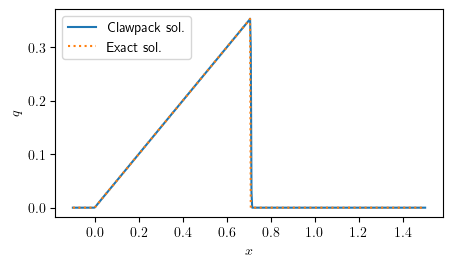

In [12]:
claw = setup()
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]

fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]
s = qtrue(x,t)
ax.plot(x, w, label='Clawpack sol.')
ax.plot(x, s, ':',label='Exact sol.')
ax.legend(loc='upper left')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("InitialValueBurgerClaw.pdf")

In [15]:
# Plotting the frames at different times
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    L    = 1.5
    hmin = 0
    hmax = 0.5
    fig, axes = plt.subplots(figsize=(5, 3))
    
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$u(x, t)$',fontsize=14)
    axes.set_xlim((0,L))
    axes.set_ylim(( hmin, hmax))
    text = axes.text(L/2, hmin+0.8*(hmax-hmin)  , '')
    
    frame = claw.frames[i]
    w  = frame.q[0,:]
    x  = frame.state.grid.c_centers
    x  = x[0]
    dt = claw.tfinal/claw.num_output_times
    t  = dt*i
    val= f'{t:.2f}'
    text.set_text(r'$  t = {} s$  '.format(val)) 
    axes.plot(x, w, label='Clawpack sol.')
    s = qtrue(x,t)
 
    axes.plot(x, s, ':',label='Exact sol.')
    axes.legend(loc='upper left')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs) 

interactive(children=(IntSlider(value=0, description='frameno', max=30), Output()), _dom_classes=('widget-inte…

In [ ]:
# Exporting the frames for latex
import os
from os.path import expanduser
# Finding the home and current directories
home = expanduser("~")
cwd = os.getcwd()
user_directory = cwd

newdir = 'Burgers_IC_Exact'
if not os.path.isdir(newdir): os.mkdir(user_directory+"/"+newdir)
for i in range(len(figs)):
    figs[i].savefig(user_directory+'/'+newdir+'/Frame'+str(i)+'.png', bbox_inches='tight',dpi=300)

In [9]:
 
def burgers_animation():
    import matplotlib.animation
    import numpy
 
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., 1.5 , 500)

    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$u(x, t)$',fontsize=14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0, .5))
    axes.set_title(" ")
    text = axes.text(1.0, 0.4, '')
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((0,.6))

        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], qinit(x_true[0]), 'k--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
     
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [qinit(x_true)])
        tt = claw.frames[n].t
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        #text.set_text(rf't = {tt:.2f} s' )
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)

from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

In [60]:
anim.save('BurgersTriangle.mp4', fps=1,writer="ffmpeg",dpi=300)



2024-01-16 16:08:42,849 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-01-16 16:08:42,850 INFO CLAW: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 1 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y BurgersTriangle.mp4
